Math 156 Final Project: CNN for Car Classification

In [ ]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import files
import cv2
import zipfile

Uploading dataset folders into Google Colab.

In [ ]:
uploaded = files.upload()

Saving Dataset.zip to Dataset.zip


In [ ]:
# Extract the uploaded .zip file
zip_file = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('dataset')

Removing .DS_store folder.

In [ ]:
dataset_path = 'dataset/Dataset'

# Initialize arrays
images = []
labels = []

# Function to clean directories
def clean_ds_store(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file == ".DS_Store":
                file_path = os.path.join(root, file)
                os.remove(file_path)

                print(f"Removed: {file_path}")

clean_ds_store(dataset_path)

# List the class folders
classes = sorted(os.listdir(dataset_path))  # Sort to maintain consistent order
print("Classes:", classes)

Removed: dataset/Dataset/.DS_Store
Classes: ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']


Loading, preprocessing, and labeling images from class folders into numpy arrays.

In [ ]:
# Restructuring the dataset

# Loop through each class folder
for label_idx, folder in enumerate(classes):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):  # Check that it is a folder
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            try:
                # Load and preprocess the image
                img = load_img(img_path, target_size=(128, 128))  # Resize to (128, 128)
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(label_idx)  # Assign label based on folder index
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

# Convert to numpy arrays
images = np.array(images, dtype='float32') / 255.0  # Normalize to [0, 1]
labels = np.array(labels)

# Verify shapes and classes
print("Number of images:", images.shape[0])
print("Number of labels:", labels.shape[0])
print("Label distribution:", {cls: sum(labels == i) for i, cls in enumerate(classes)})

Number of images: 4165
Number of labels: 4165
Label distribution: {'Audi': 1013, 'Hyundai Creta': 338, 'Mahindra Scorpio': 391, 'Rolls Royce': 385, 'Swift': 526, 'Tata Safari': 547, 'Toyota Innova': 965}


Exploratory Data Analysis

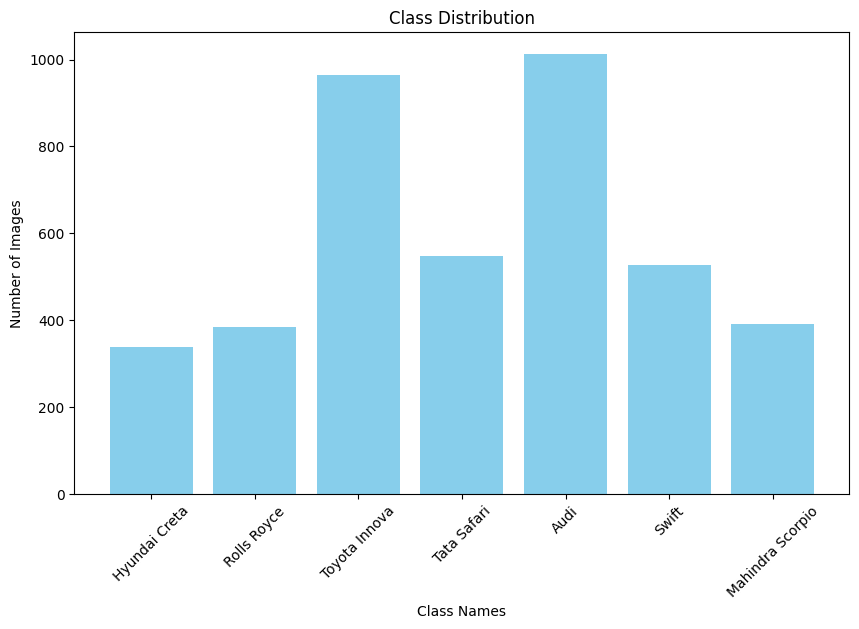

In [ ]:
# Count images per class
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        class_counts[class_name] = len(os.listdir(class_folder))

# Class distribution plot
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

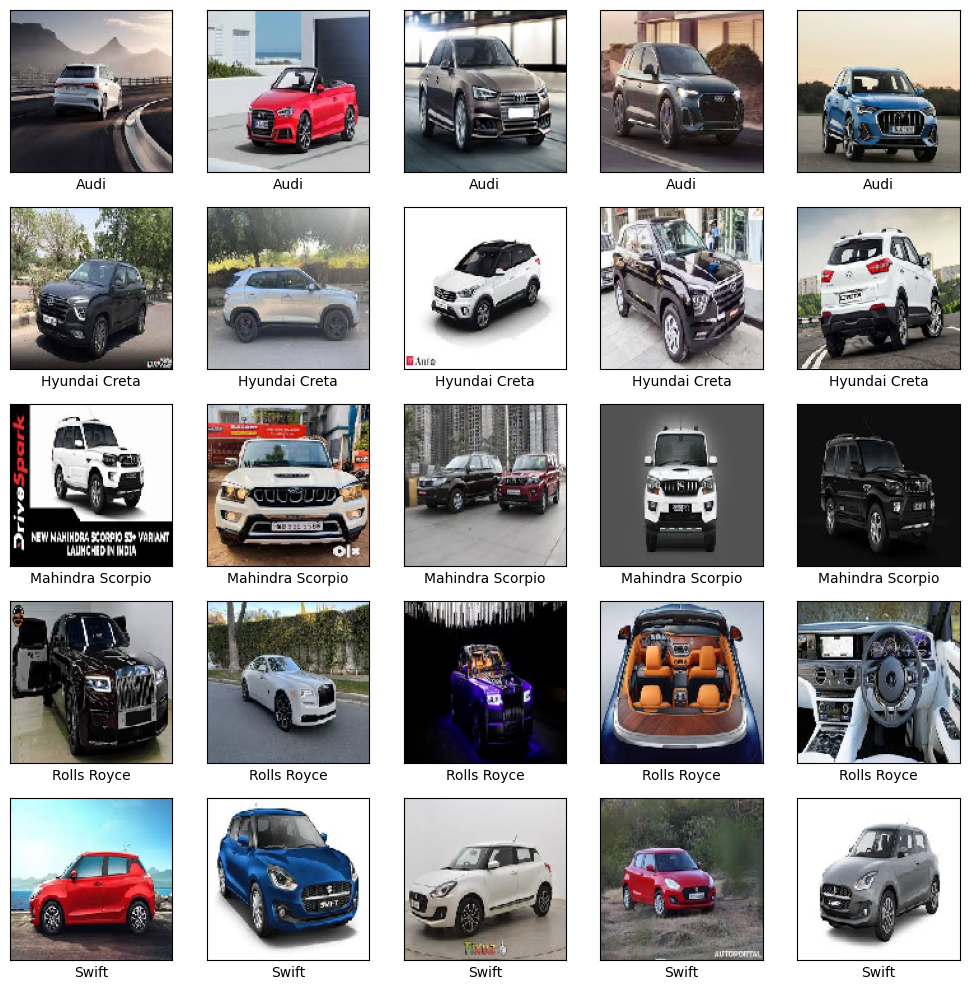

In [ ]:
# Verifying the data

# Load a sample batch of images and their labels
sample_images = []
sample_labels = []

# Loop through each class folder
for label_idx, folder in enumerate(classes):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):  # Ensure it's a folder
        # Load up to 5 images per class for visualization
        for img_name in os.listdir(folder_path)[:5]:
            img_path = os.path.join(folder_path, img_name)
            img = load_img(img_path, target_size=(128, 128))  # Resize to (128x128)
            sample_images.append(img_to_array(img) / 255.0)  # Normalize
            sample_labels.append(label_idx)

# Convert to numpy arrays
sample_images = np.array(sample_images)
sample_labels = np.array(sample_labels)

max_images = 25
sample_images = sample_images[:max_images]
sample_labels = sample_labels[:max_images]

# Display the images in a grid
plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    plt.subplot(5, 5, i + 1)  # 5x5 grid
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_images[i])  # Show image
    plt.xlabel(classes[sample_labels[i]])  # Label from folder name
plt.tight_layout()
plt.show()

Splitting data into train and test.

In [ ]:
# Split data

X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=len(classes))
y_test = to_categorical(y_test, num_classes=len(classes))

# Verify splits
print("Train images:", X_train.shape)
print("Test images:", X_test.shape)
print("Train labels:", y_train.shape)
print("Test labels:", y_test.shape)

Train images: (3332, 128, 128, 3)
Test images: (833, 128, 128, 3)
Train labels: (3332, 7)
Test labels: (833, 7)


Structuring the model

In [ ]:
# Model initialization
IMG_SIZE = 128

model = Sequential()

# Adding layers
model.add(Conv2D(32, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

# Model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,393,223 (28.20 MB)

 Trainable params: 7,393,223 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train, epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 98s 886ms/step - accuracy: 0.2736 - loss: 2.0693 - val_accuracy: 0.4178 - val_loss: 1.5915
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 145s 936ms/step - accuracy: 0.4976 - loss: 1.4417 - val_accuracy: 0.5774 - val_loss: 1.2142
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.6742 - loss: 0.9245 - val_accuracy: 0.6122 - val_loss: 1.1502
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 97s 923ms/step - accuracy: 0.8094 - loss: 0.5586 - val_accuracy: 0.6531 - val_loss: 1.1891
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 135s 856ms/step - accuracy: 0.8953 - loss: 0.3311 - val_accuracy: 0.6927 - val_loss: 1.0889
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 141s 846ms/step - accuracy: 0.9210 - loss: 0.2270 - val_accuracy: 0.6855 - val_loss: 1.1802
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 144s 865ms/step - accuracy: 0.9475 - loss: 0.1690 - val_accuracy: 0.6759 - val_loss: 1.1894
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 93s 886ms/step - accuracy: 0.9681 - loss:

Evaluating the model

27/27 - 6s - 240ms/step - accuracy: 0.6711 - loss: 1.5052
Test Accuracy: 67.11%


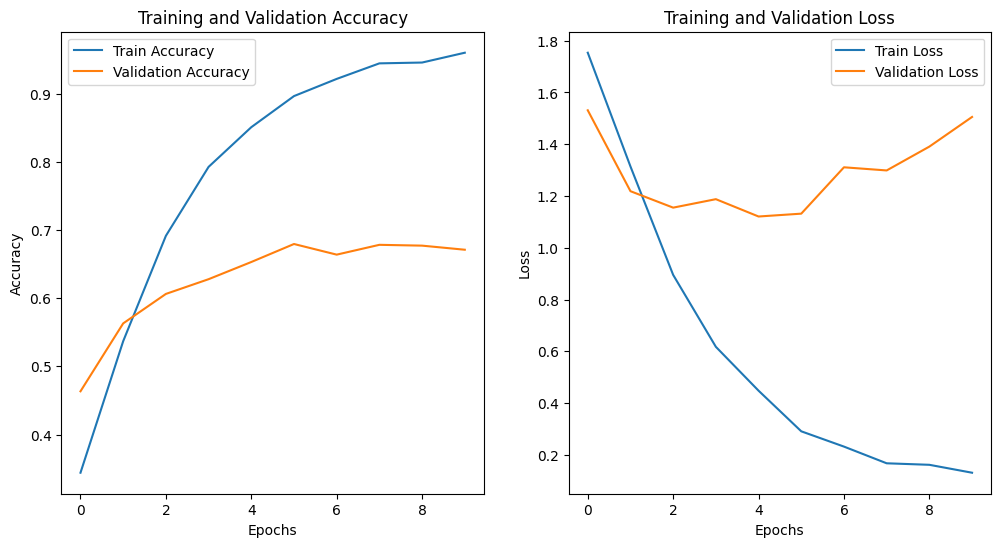

In [ ]:
# Evaluating the model
test_scores = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_scores[1]*100:.2f}%")

# Plotting training and validation metrics
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(10), history.history['accuracy'], label='Train Accuracy')
plt.plot(range(10), history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(10), history.history['loss'], label='Train Loss')
plt.plot(range(10), history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step


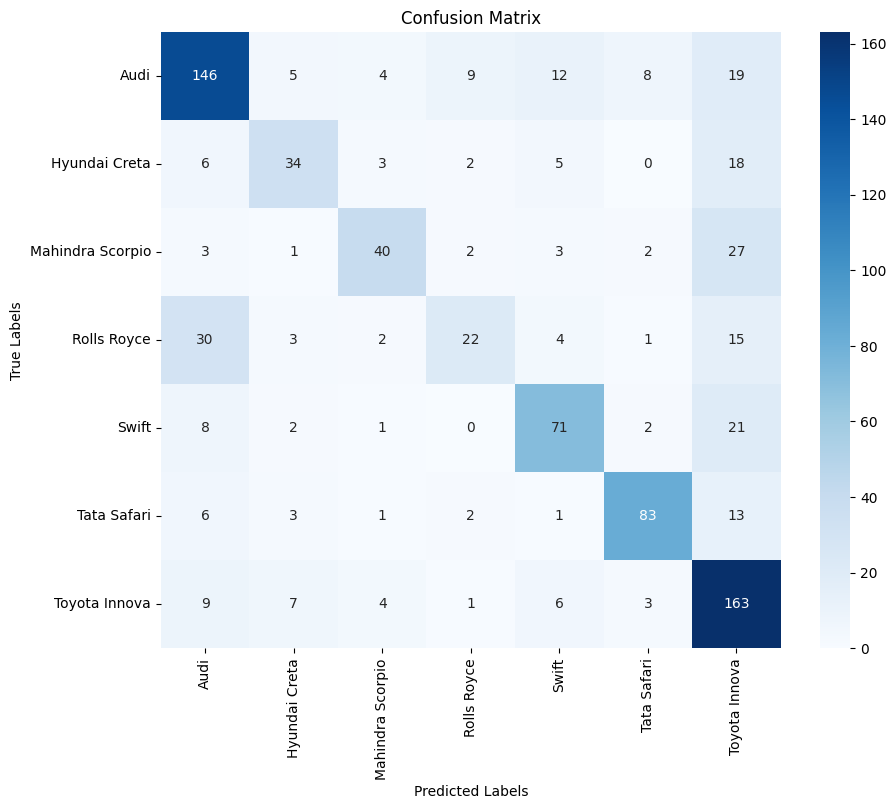

In [ ]:
# Confusion matrix

# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert predicted probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded true labels to class indices
y_true = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()